# Import Dataset

In [1]:
import os
import pandas as pd

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)
    
    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)
            
            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'
                
                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)
                    
                    # Load and preprocess the image as needed (you can add this part here)
                    
                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)



In [2]:
# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# You can display the first few rows of the DataFrame to verify
print(df.head())


                                           filepaths  \
0  /kaggle/input/hair-data/labeled_dataset/No hai...   
1  /kaggle/input/hair-data/labeled_dataset/No hai...   
2  /kaggle/input/hair-data/labeled_dataset/No hai...   
3  /kaggle/input/hair-data/labeled_dataset/No hai...   
4  /kaggle/input/hair-data/labeled_dataset/No hai...   

                      labels  
0  No hair loss_No Hair Loss  
1  No hair loss_No Hair Loss  
2  No hair loss_No Hair Loss  
3  No hair loss_No Hair Loss  
4  No hair loss_No Hair Loss  


In [3]:
df.head(5)

,filepaths,labels
0,/kaggle/input/hair-data/labeled_dataset/No hai...,No hair loss_No Hair Loss
1,/kaggle/input/hair-data/labeled_dataset/No hai...,No hair loss_No Hair Loss
2,/kaggle/input/hair-data/labeled_dataset/No hai...,No hair loss_No Hair Loss
3,/kaggle/input/hair-data/labeled_dataset/No hai...,No hair loss_No Hair Loss
4,/kaggle/input/hair-data/labeled_dataset/No hai...,No hair loss_No Hair Loss


In [4]:
df['labels'].unique().size

15

# Data Generator

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


# Check Data Generator Initialization:

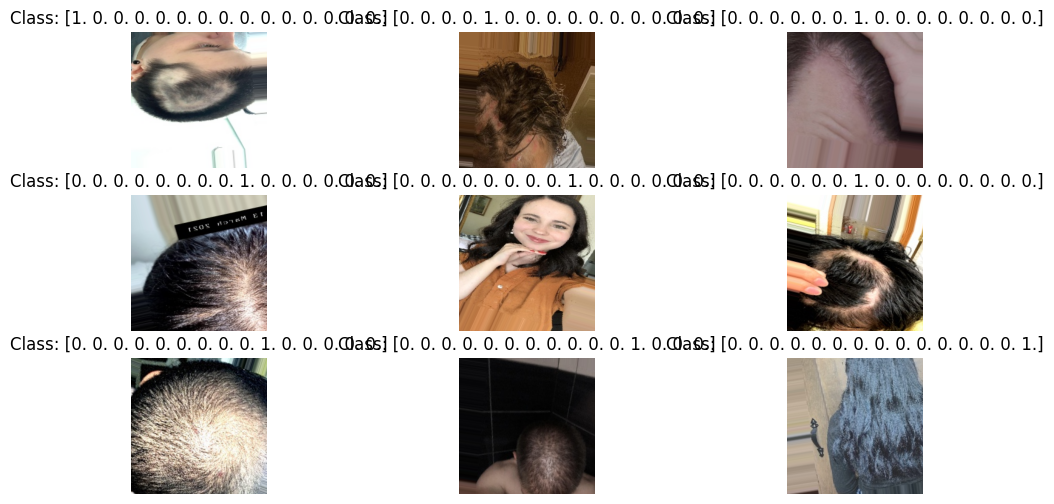

In [6]:
# Get a batch of images and labels from the training generator
images, labels = next(train_gen)

# Display a few sample images from the batch
plt.figure(figsize=(12, 6))
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i]}")
    plt.axis("off")
plt.show()

In [7]:
# Get the unique labels from your DataFrame
unique_labels = train_df['labels'].unique()

# Count the number of unique labels to get the number of classes
num_classes = len(unique_labels)

# Print the number of classes
print("Number of classes:", num_classes)


Number of classes: 15


In [8]:
print("Number of samples in training set:", train_gen.samples)
print("Number of samples in validation set:", valid_gen.samples)
print("Number of samples in test set:", test_gen.samples)


Number of samples in training set: 23341
Number of samples in validation set: 2918
Number of samples in test set: 2918


## Model Structure

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB3

# Define model parameters
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(train_gen.class_indices)  # Number of classes in your dataset

# Create the base model (EfficientNetB3)
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Create the custom classification head
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),  # You can modify the number of units as needed
    Dropout(rate=0.5),  # You can adjust the dropout rate
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 11,187,006
Trainable params: 11,096,631
Non

## Tranning Model CallBacks

In [12]:
import tensorflow as tf
import numpy as np
import time

# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True


# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)

# Define other callbacks you might want to use, such as ModelCheckpoint
# For example, if you want to use ModelCheckpoint to save the best model weights during training:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_weights.h5", monitor="val_loss", save_best_only=True, mode="min")

# Define the number of epochs
num_epochs = 10

# Training the model with your custom callback
model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.8149Epoch 1/100
Training - loss: 0.5619 - accuracy: 0.8149
Validation - loss: 3.2226 - accuracy: 0.1624
Best validation loss at epoch 1: 3.2226
730/730 [==============================] - 392s 537ms/step - loss: 0.5619 - accuracy: 0.8149 - val_loss: 3.2226 - val_accuracy: 0.1624
Epoch 2/10
730/730 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8623Epoch 2/100
Training - loss: 0.4188 - accuracy: 0.8623
Validation - loss: 7.1085 - accuracy: 0.1083
Best validation loss at epoch 1: 3.2226
730/730 [==============================] - 396s 542ms/step - loss: 0.4188 - accuracy: 0.8623 - val_loss: 7.1085 - val_accuracy: 0.1083
Epoch 3/10
730/730 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8922Epoch 3/100
Training - loss: 0.3190 - accuracy: 0.8922
Validation - loss: 67.4116 - accuracy: 0.0905
Best validation loss at epoch 1: 3.2226
730/730 [===============

KeyboardInterrupt: 

## InseptionV3

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 5

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  # Add this import statement
import tensorflow as tf

In [5]:
# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

# Create the base model (InceptionV3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)


87910968/87910968 [==============================] - 0s 0us/step


In [6]:
# Define the number of epochs
num_epochs = 10

In [8]:
# Training the model with your custom callback
model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
history = model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.6738Epoch 1/100
Training - loss: 0.9587 - accuracy: 0.6738
Validation - loss: 0.9091 - accuracy: 0.6847
Best validation loss at epoch 1: 0.9091
730/730 [==============================] - 345s 472ms/step - loss: 0.9587 - accuracy: 0.6738 - val_loss: 0.9091 - val_accuracy: 0.6847
Epoch 2/10
730/730 [==============================] - ETA: 0s - loss: 0.8579 - accuracy: 0.7061Epoch 2/100
Training - loss: 0.8579 - accuracy: 0.7061
Validation - loss: 0.8191 - accuracy: 0.7200
Best validation loss at epoch 2: 0.8191
730/730 [==============================] - 296s 405ms/step - loss: 0.8579 - accuracy: 0.7061 - val_loss: 0.8191 - val_accuracy: 0.7200
Epoch 3/10
730/730 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7272Epoch 3/100
Training - loss: 0.7951 - accuracy: 0.7272
Validation - loss: 0.7548 - accuracy: 0.7399
Best validation loss at epoch 3: 0.7548
730/730 [================

In [10]:
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'history'

In [16]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

92/92 [==============================] - 7s 75ms/step


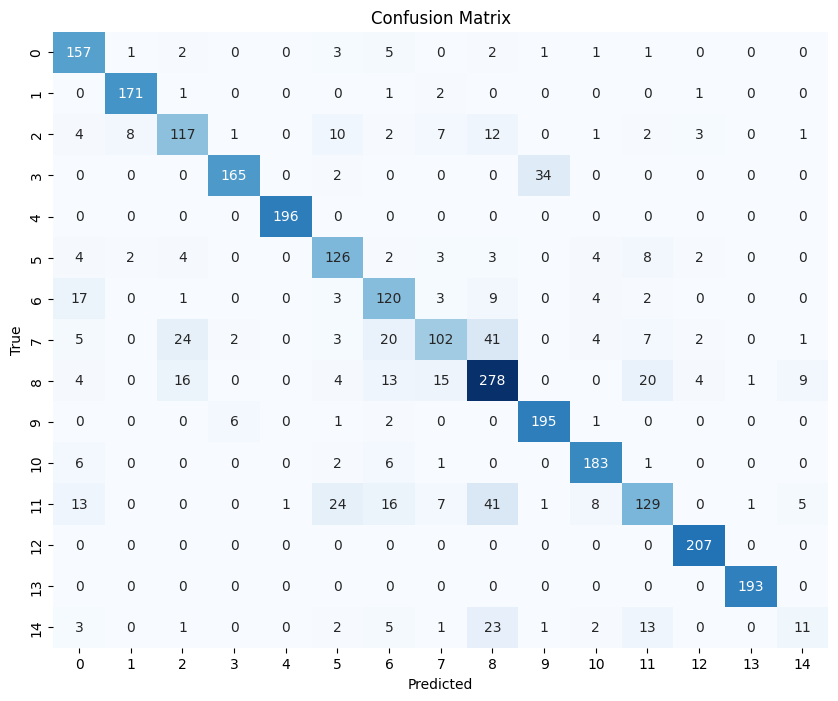

                                               precision    recall  f1-score   support

                Advance Stage_Alopecia areata       0.74      0.91      0.81       173
                     Advance Stage_Dermatitis       0.94      0.97      0.96       176
        Advance Stage_Female pattern baldness       0.70      0.70      0.70       168
                   Advance Stage_Folliculitis       0.95      0.82      0.88       201
                  Advance Stage_Lichen Planus       0.99      1.00      1.00       196
          Advance Stage_Male pattern baldness       0.70      0.80      0.75       158
        Early stage hair loss_Alopecia areata       0.62      0.75      0.68       159
             Early stage hair loss_Dermatitis       0.72      0.48      0.58       211
Early stage hair loss_Female pattern baldness       0.68      0.76      0.72       364
           Early stage hair loss_Folliculitis       0.84      0.95      0.89       205
          Early stage hair loss_Lichen Pla

In [17]:
# Get the true labels and predicted labels for the test set
true_labels = test_gen.classes  # Use test_gen.classes to get true labels
predicted_labels = model.predict(test_gen).argmax(axis=1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)


## Take Lables For Web Application

In [20]:
# Extract unique class labels from the 'labels' column
unique_labels = df['labels'].unique()

# Convert to a list (optional, if not already a list)
unique_labels = unique_labels.tolist()

# Now, 'unique_labels' contains all the unique class labels in your dataset


unique_labels

['No hair loss_No Hair Loss',
 'Advance Stage_Dermatitis',
 'Advance Stage_Male pattern baldness',
 'Advance Stage_Female pattern baldness',
 'Advance Stage_Lichen Planus',
 'Advance Stage_Alopecia areata',
 'Advance Stage_Folliculitis',
 'Early stage hair loss_Dermatitis',
 'Early stage hair loss_Male pattern baldness',
 'Early stage hair loss_Female pattern baldness',
 'Early stage hair loss_Tinea capitis',
 'Early stage hair loss_Lichen Planus',
 'Early stage hair loss_Alopecia areata',
 'Early stage hair loss_Tracion alopecia',
 'Early stage hair loss_Folliculitis']

## Model Save

In [21]:
# Save the trained model
model.save('hair_disease_classifier.h5')


## VGG16

In [1]:
import os
import pandas as pd

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)
    
    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)
            
            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'
                
                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)
                    
                    # Load and preprocess the image as needed (you can add this part here)
                    
                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

In [2]:
# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# You can display the first few rows of the DataFrame to verify
print(df.head())


                                           filepaths  \
0  /kaggle/input/hair-data/labeled_dataset/No hai...   
1  /kaggle/input/hair-data/labeled_dataset/No hai...   
2  /kaggle/input/hair-data/labeled_dataset/No hai...   
3  /kaggle/input/hair-data/labeled_dataset/No hai...   
4  /kaggle/input/hair-data/labeled_dataset/No hai...   

                      labels  
0  No hair loss_No Hair Loss  
1  No hair loss_No Hair Loss  
2  No hair loss_No Hair Loss  
3  No hair loss_No Hair Loss  
4  No hair loss_No Hair Loss  


In [3]:
df['labels'].unique().size

15

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


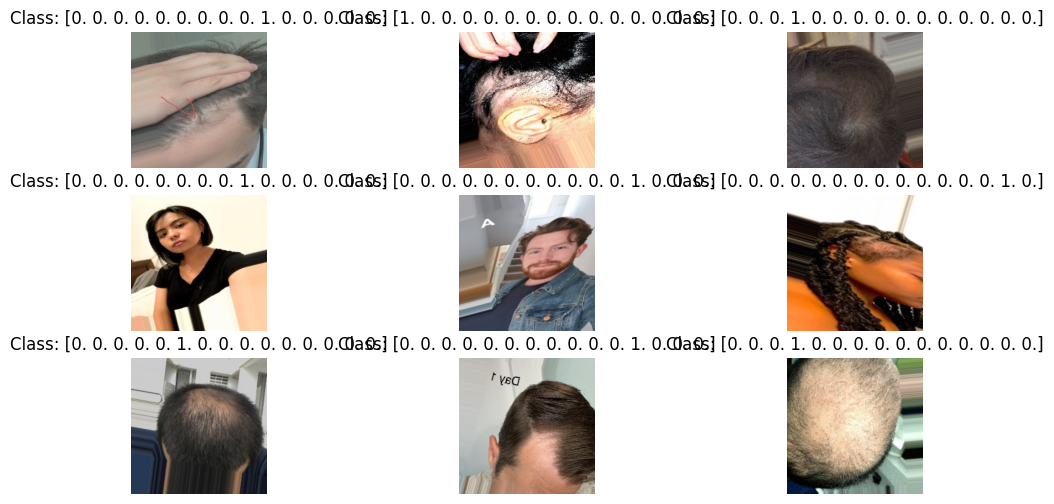

In [5]:
# Get a batch of images and labels from the training generator
images, labels = next(train_gen)

# Display a few sample images from the batch
plt.figure(figsize=(12, 6))
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i]}")
    plt.axis("off")
plt.show()

In [6]:
print("Number of samples in training set:", train_gen.samples)
print("Number of samples in validation set:", valid_gen.samples)
print("Number of samples in test set:", test_gen.samples)


Number of samples in training set: 23341
Number of samples in validation set: 2918
Number of samples in test set: 2918


In [8]:
# Define the number of classes
num_classes = len(train_gen.class_indices)

In [9]:
num_classes

15

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(num_classes, activation='softmax')(x)  # Define num_classes based on your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)

# Define the number of epochs
num_epochs = 15

In [11]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/15
730/730 [==============================] - ETA: 0s - loss: 1.7075 - accuracy: 0.4648Epoch 1/100
Training - loss: 1.7075 - accuracy: 0.4648
Validation - loss: 16.7131 - accuracy: 0.5637
Best validation loss at epoch 1: 16.7131
730/730 [==============================] - 434s 582ms/step - loss: 1.7075 - accuracy: 0.4648 - val_loss: 16.7131 - val_accuracy: 0.5637
Epoch 2/15
730/730 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.5704Epoch 2/100
Training - loss: 1.3009 - accuracy: 0.5704
Validation - loss: 36.0559 - accuracy: 0.6035
Best validation loss at epoch 1: 16.7131
730/730 [==============================] - 301s 413ms/step - loss: 1.3009 - accuracy: 0.5704 - val_loss: 36.0559 - val_accuracy: 0.6035
Epoch 3/15
730/730 [==============================] - ETA: 0s - loss: 1.1915 - accuracy: 0.6032Epoch 3/100
Training - loss: 1.1915 - accuracy: 0.6032
Validation - loss: 40.7350 - accuracy: 0.6367
Best validation loss at epoch 1: 16.7131
730/730 [========


Do you wish to stop training? (yes/no):  yes


Epoch 11/100
Training - loss: 0.8356 - accuracy: 0.7157
Validation - loss: 72.5838 - accuracy: 0.7286
Best validation loss at epoch 1: 16.7131
730/730 [==============================] - 315s 431ms/step - loss: 0.8356 - accuracy: 0.7157 - val_loss: 72.5838 - val_accuracy: 0.7286


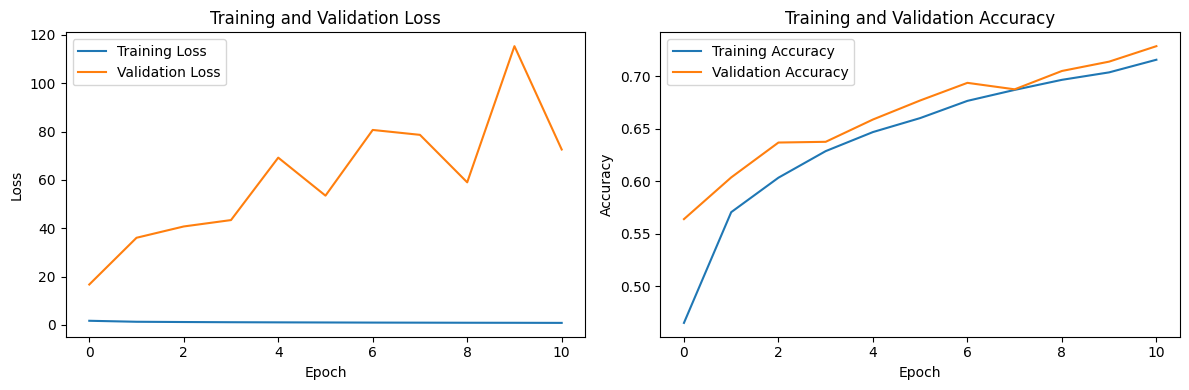

In [12]:
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

92/92 [==============================] - 25s 268ms/step


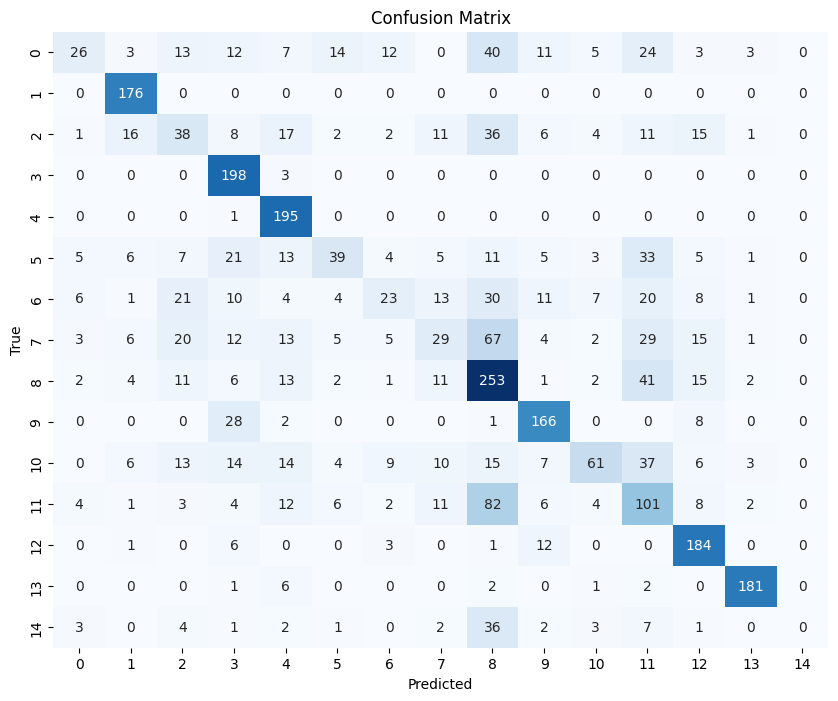

                                               precision    recall  f1-score   support

                Advance Stage_Alopecia areata       0.52      0.15      0.23       173
                     Advance Stage_Dermatitis       0.80      1.00      0.89       176
        Advance Stage_Female pattern baldness       0.29      0.23      0.26       168
                   Advance Stage_Folliculitis       0.61      0.99      0.76       201
                  Advance Stage_Lichen Planus       0.65      0.99      0.78       196
          Advance Stage_Male pattern baldness       0.51      0.25      0.33       158
        Early stage hair loss_Alopecia areata       0.38      0.14      0.21       159
             Early stage hair loss_Dermatitis       0.32      0.14      0.19       211
Early stage hair loss_Female pattern baldness       0.44      0.70      0.54       364
           Early stage hair loss_Folliculitis       0.72      0.81      0.76       205
          Early stage hair loss_Lichen Pla

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Get the true labels and predicted labels for the test set
true_labels = test_gen.classes  # Use test_gen.classes to get true labels
predicted_labels = model.predict(test_gen).argmax(axis=1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

In [ ]:
# Save the trained model
model.save('vgg16.h5')

## Restnet50

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 10

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

# Load the ResNet-50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(num_classes, activation='softmax')(x)  # Define num_classes based on your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)




94765736/94765736 [==============================] - 0s 0us/step


In [17]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 2.5926 - accuracy: 0.1575Epoch 1/100
Training - loss: 2.5926 - accuracy: 0.1575
Validation - loss: 2.4941 - accuracy: 0.1772
Best validation loss at epoch 1: 2.4941
730/730 [==============================] - 304s 411ms/step - loss: 2.5926 - accuracy: 0.1575 - val_loss: 2.4941 - val_accuracy: 0.1772
Epoch 2/10
 60/730 [=>............................] - ETA: 4:24 - loss: 2.5149 - accuracy: 0.1745

KeyboardInterrupt: 

## Model From Scratch 

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 10

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [19]:
# Define your custom model architecture
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Define num_classes based on your dataset
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for model training
checkpoint = ModelCheckpoint("custom_model_best_weights.h5", monitor="val_loss", save_best_only=True, mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)



In [20]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=num_epochs,
    callbacks=[checkpoint, early_stopping]
)

# Save the trained model
model.save("custom_model.h5")

Epoch 1/10
730/730 [==============================] - 294s 397ms/step - loss: 3.8713 - accuracy: 0.1478 - val_loss: 3.0418 - val_accuracy: 0.1717
Epoch 2/10
116/730 [===>..........................] - ETA: 3:52 - loss: 2.6797 - accuracy: 0.1546

KeyboardInterrupt: 

## VGG 19

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 10

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [22]:
# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

In [23]:
## import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers with dropout for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout with a rate of 0.5
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)


80134624/80134624 [==============================] - 0s 0us/step


In [24]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 2.0299 - accuracy: 0.3668Epoch 1/100
Training - loss: 2.0299 - accuracy: 0.3668
Validation - loss: 34.8387 - accuracy: 0.4719
Best validation loss at epoch 1: 34.8387
730/730 [==============================] - 310s 422ms/step - loss: 2.0299 - accuracy: 0.3668 - val_loss: 34.8387 - val_accuracy: 0.4719
Epoch 2/10
730/730 [==============================] - ETA: 0s - loss: 1.6564 - accuracy: 0.4698Epoch 2/100
Training - loss: 1.6564 - accuracy: 0.4698
Validation - loss: 78.5028 - accuracy: 0.5209
Best validation loss at epoch 1: 34.8387
730/730 [==============================] - 306s 419ms/step - loss: 1.6564 - accuracy: 0.4698 - val_loss: 78.5028 - val_accuracy: 0.5209
Epoch 3/10
559/730 [=====================>........] - ETA: 1:08 - loss: 1.5364 - accuracy: 0.4962

KeyboardInterrupt: 

In [ ]:
# Save the trained model
model.save("vgg19_model.h5")

## DenseNet

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 10

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [26]:
# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the DenseNet121 model pre-trained on ImageNet data
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers with dropout for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout with a rate of 0.5
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)



29084464/29084464 [==============================] - 0s 0us/step


In [28]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 1.3169 - accuracy: 0.5771Epoch 1/100
Training - loss: 1.3169 - accuracy: 0.5771
Validation - loss: 0.9288 - accuracy: 0.6947
Best validation loss at epoch 1: 0.9288
730/730 [==============================] - 361s 416ms/step - loss: 1.3169 - accuracy: 0.5771 - val_loss: 0.9288 - val_accuracy: 0.6947
Epoch 2/10
730/730 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6656Epoch 2/100
Training - loss: 0.9875 - accuracy: 0.6656
Validation - loss: 0.8105 - accuracy: 0.7231
Best validation loss at epoch 2: 0.8105
730/730 [==============================] - 297s 407ms/step - loss: 0.9875 - accuracy: 0.6656 - val_loss: 0.8105 - val_accuracy: 0.7231
Epoch 3/10
730/730 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.6928Epoch 3/100
Training - loss: 0.9053 - accuracy: 0.6928
Validation - loss: 0.7297 - accuracy: 0.7563
Best validation loss at epoch 3: 0.7297
730/730 [================

In [29]:
# Save the trained model
model.save("densenet_model.h5")

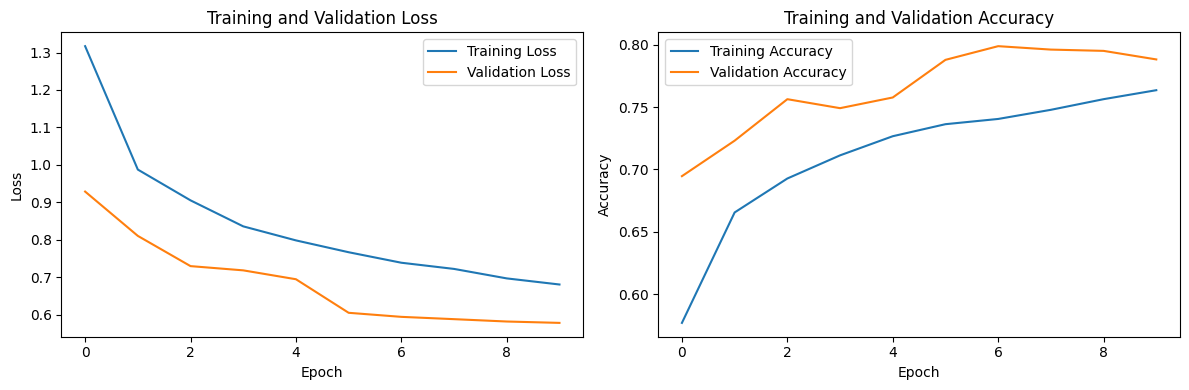

In [30]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

92/92 [==============================] - 12s 108ms/step


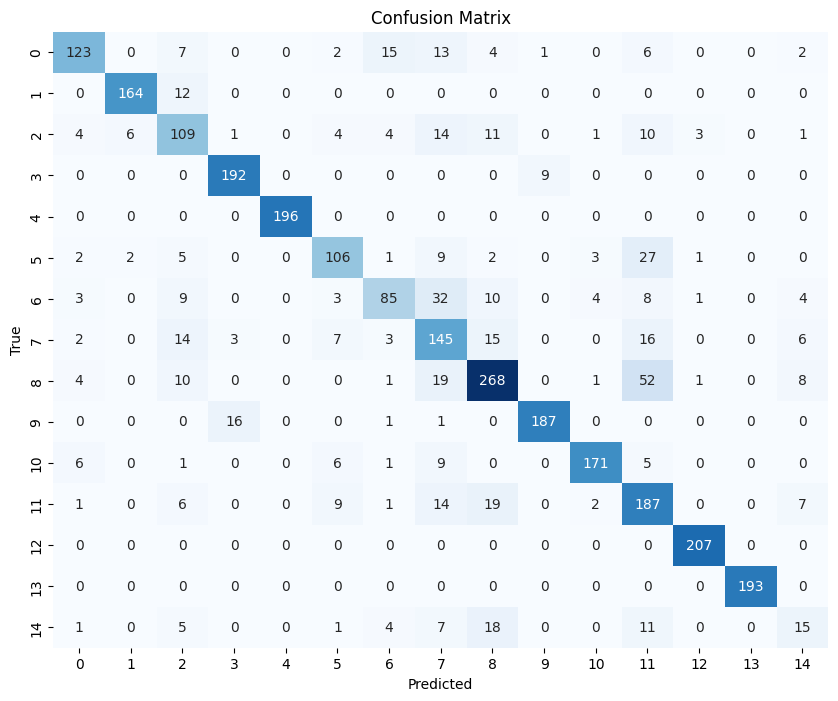

                                               precision    recall  f1-score   support

                Advance Stage_Alopecia areata       0.84      0.71      0.77       173
                     Advance Stage_Dermatitis       0.95      0.93      0.94       176
        Advance Stage_Female pattern baldness       0.61      0.65      0.63       168
                   Advance Stage_Folliculitis       0.91      0.96      0.93       201
                  Advance Stage_Lichen Planus       1.00      1.00      1.00       196
          Advance Stage_Male pattern baldness       0.77      0.67      0.72       158
        Early stage hair loss_Alopecia areata       0.73      0.53      0.62       159
             Early stage hair loss_Dermatitis       0.55      0.69      0.61       211
Early stage hair loss_Female pattern baldness       0.77      0.74      0.75       364
           Early stage hair loss_Folliculitis       0.95      0.91      0.93       205
          Early stage hair loss_Lichen Pla

In [31]:
# Get the true labels and predicted labels for the test set
true_labels = test_gen.classes  # Use test_gen.classes to get true labels
predicted_labels = model.predict(test_gen).argmax(axis=1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

## MobileNet

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 10

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [33]:
# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the MobileNetV2 model pre-trained on ImageNet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers with dropout for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout with a rate of 0.5
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)


9406464/9406464 [==============================] - 0s 0us/step


In [35]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/10
730/730 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.5765Epoch 1/100
Training - loss: 1.3085 - accuracy: 0.5765
Validation - loss: 0.9383 - accuracy: 0.6857
Best validation loss at epoch 1: 0.9383
730/730 [==============================] - 288s 390ms/step - loss: 1.3085 - accuracy: 0.5765 - val_loss: 0.9383 - val_accuracy: 0.6857
Epoch 2/10
730/730 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.6621Epoch 2/100
Training - loss: 1.0003 - accuracy: 0.6621
Validation - loss: 0.8705 - accuracy: 0.6953
Best validation loss at epoch 2: 0.8705
730/730 [==============================] - 288s 395ms/step - loss: 1.0003 - accuracy: 0.6621 - val_loss: 0.8705 - val_accuracy: 0.6953
Epoch 3/10
730/730 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.6882Epoch 3/100
Training - loss: 0.9089 - accuracy: 0.6882
Validation - loss: 0.7589 - accuracy: 0.7375
Best validation loss at epoch 3: 0.7589
730/730 [================

In [36]:
# Save the trained model
model.save("mobilenet_model.h5")

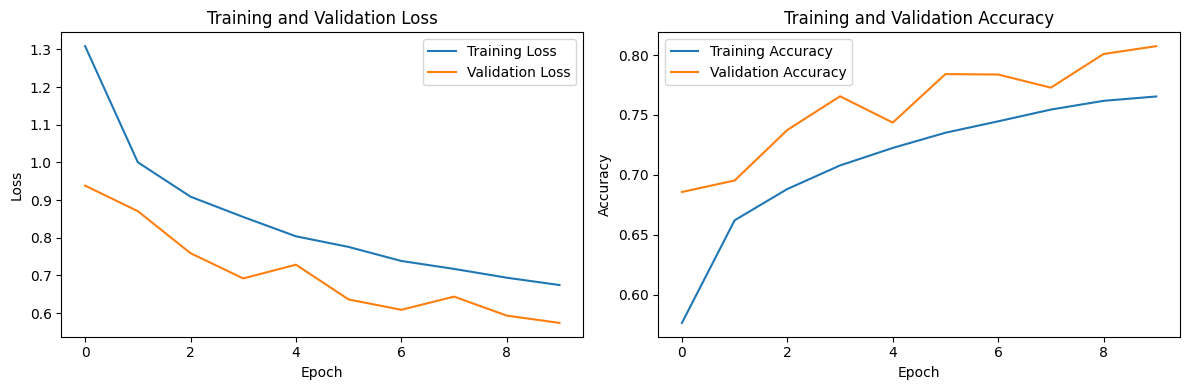

In [37]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

92/92 [==============================] - 10s 106ms/step


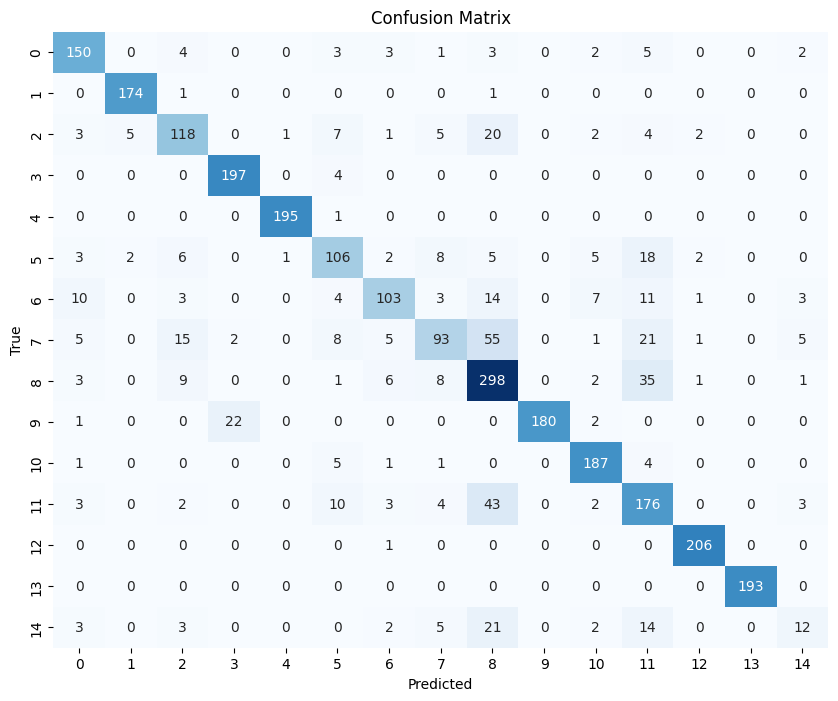

                                               precision    recall  f1-score   support

                Advance Stage_Alopecia areata       0.82      0.87      0.85       173
                     Advance Stage_Dermatitis       0.96      0.99      0.97       176
        Advance Stage_Female pattern baldness       0.73      0.70      0.72       168
                   Advance Stage_Folliculitis       0.89      0.98      0.93       201
                  Advance Stage_Lichen Planus       0.99      0.99      0.99       196
          Advance Stage_Male pattern baldness       0.71      0.67      0.69       158
        Early stage hair loss_Alopecia areata       0.81      0.65      0.72       159
             Early stage hair loss_Dermatitis       0.73      0.44      0.55       211
Early stage hair loss_Female pattern baldness       0.65      0.82      0.72       364
           Early stage hair loss_Folliculitis       1.00      0.88      0.94       205
          Early stage hair loss_Lichen Pla

In [38]:
# Get the true labels and predicted labels for the test set
true_labels = test_gen.classes  # Use test_gen.classes to get true labels
predicted_labels = model.predict(test_gen).argmax(axis=1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

## Xception

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
# Define the root directory of your modified dataset
data_dir = '/kaggle/input/hair-data/labeled_dataset'

# Create lists to store data and labels
data = []
labels = []

# Loop through the stages and diseases
for stage in os.listdir(data_dir):
    stage_path = os.path.join(data_dir, stage)

    if os.path.isdir(stage_path):
        for disease in os.listdir(stage_path):
            disease_path = os.path.join(stage_path, disease)

            if os.path.isdir(disease_path):
                # Label format: Stage_Disease
                label = f'{stage}_{disease}'

                for image_file in os.listdir(disease_path):
                    image_path = os.path.join(disease_path, image_file)

                    # Load and preprocess the image as needed (you can add this part here)

                    # Add the image data and label to the lists
                    data.append(image_path)
                    labels.append(label)

# Create a DataFrame from the lists of data and labels
df = pd.DataFrame({'filepaths': data, 'labels': labels})

# Split the DataFrame into train, validation, and test sets
def split_data(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    remaining_size = 1 - test_size
    valid_ratio = valid_size / remaining_size
    train_df, valid_df = train_test_split(train_df, test_size=valid_ratio, random_state=random_state)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df)

# Define batch size and image dimensions
batch_size = 32
img_size = (224, 224)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Define the number of epochs
num_epochs = 5

Found 23341 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.
Found 2918 validated image filenames belonging to 15 classes.


In [41]:
# Define your custom callback class
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, min_val_accuracy):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
        self.min_val_accuracy = min_val_accuracy

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get the initial learning rate and save it
        self.highest_tracc = 0.0  # Set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # Set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # Set best weights to the model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

    # This method runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if self.ask_epoch < 1:
            while True:
                ans = input('\nDo you wish to stop training? (yes/no): ')
                if ans.lower() == 'yes':
                    self.model.stop_training = True
                    break
                elif ans.lower() == 'no':
                    self.ask_epoch = self.ask_epoch_initial
                    break
        else:
            self.ask_epoch -= 1

        # Retrieve training metrics
        tr_loss = logs.get('loss')
        tr_acc = logs.get('accuracy')

        # Retrieve validation metrics
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # Monitor which metric for early stopping
        monitor = 'val_loss'  # You can change this to 'val_accuracy' if needed

        if monitor == 'val_loss':
            monitor_value = val_loss
        elif monitor == 'val_accuracy':
            monitor_value = val_acc
        else:
            msg = 'Invalid monitor: {0:s}. Valid options are: val_loss and val_accuracy.'.format(monitor)
            raise ValueError(msg)

        # Check if the current epoch has improvement
        if monitor_value < self.threshold:
            self.count += 1  # Increase the counter if there's no improvement
        else:
            self.count = 0  # Reset the counter if there's improvement

        # Save the best weights if current validation loss is the lowest so far
        if val_loss < self.lowest_vloss:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Record the current epoch
            self.lowest_vloss = val_loss

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{self.epochs}')
        print(f'Training - loss: {tr_loss:.4f} - accuracy: {tr_acc:.4f}')
        print(f'Validation - loss: {val_loss:.4f} - accuracy: {val_acc:.4f}')
        print(f'Best validation loss at epoch {self.best_epoch}: {self.lowest_vloss:.4f}')

        # Check if the minimum validation accuracy threshold is met
        if val_acc >= self.min_val_accuracy:
            self.model.stop_training = True

In [42]:
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of MyCallback with your desired parameters, including min_val_accuracy
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=99.9, factor=0.1, batches=train_gen.samples // train_gen.batch_size, epochs=100, ask_epoch=10, min_val_accuracy=0.85)




83683744/83683744 [==============================] - 1s 0us/step


In [43]:
# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs, callbacks=[my_callback])

# After training, you can retrieve the best weights using:
model.set_weights(my_callback.best_weights)

Epoch 1/5
730/730 [==============================] - ETA: 0s - loss: 1.1248 - accuracy: 0.6312Epoch 1/100
Training - loss: 1.1248 - accuracy: 0.6312
Validation - loss: 0.9125 - accuracy: 0.6868
Best validation loss at epoch 1: 0.9125
730/730 [==============================] - 305s 412ms/step - loss: 1.1248 - accuracy: 0.6312 - val_loss: 0.9125 - val_accuracy: 0.6868
Epoch 2/5
730/730 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7169Epoch 2/100
Training - loss: 0.8296 - accuracy: 0.7169
Validation - loss: 0.7793 - accuracy: 0.7300
Best validation loss at epoch 2: 0.7793
730/730 [==============================] - 299s 409ms/step - loss: 0.8296 - accuracy: 0.7169 - val_loss: 0.7793 - val_accuracy: 0.7300
Epoch 3/5
730/730 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.7486Epoch 3/100
Training - loss: 0.7316 - accuracy: 0.7486
Validation - loss: 0.7281 - accuracy: 0.7467
Best validation loss at epoch 3: 0.7281
730/730 [===================

In [44]:
# Save the trained model
model.save("xception_model.h5")

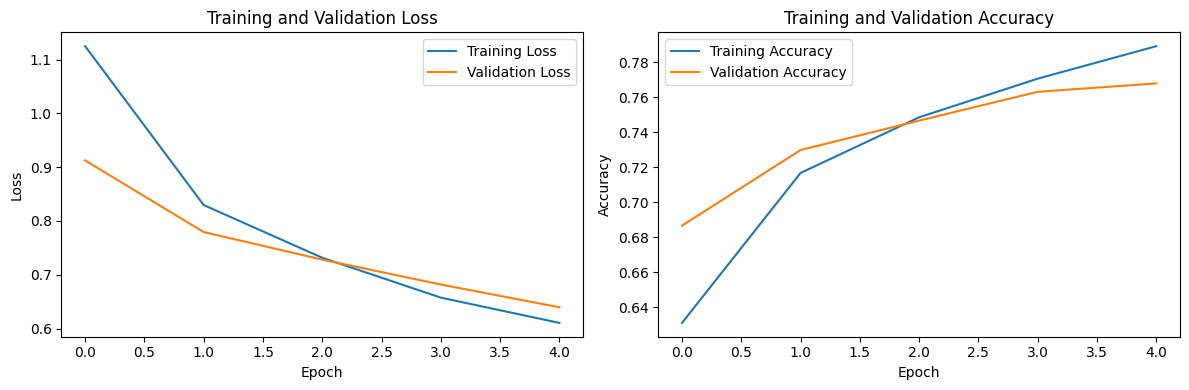

In [45]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

92/92 [==============================] - 11s 110ms/step


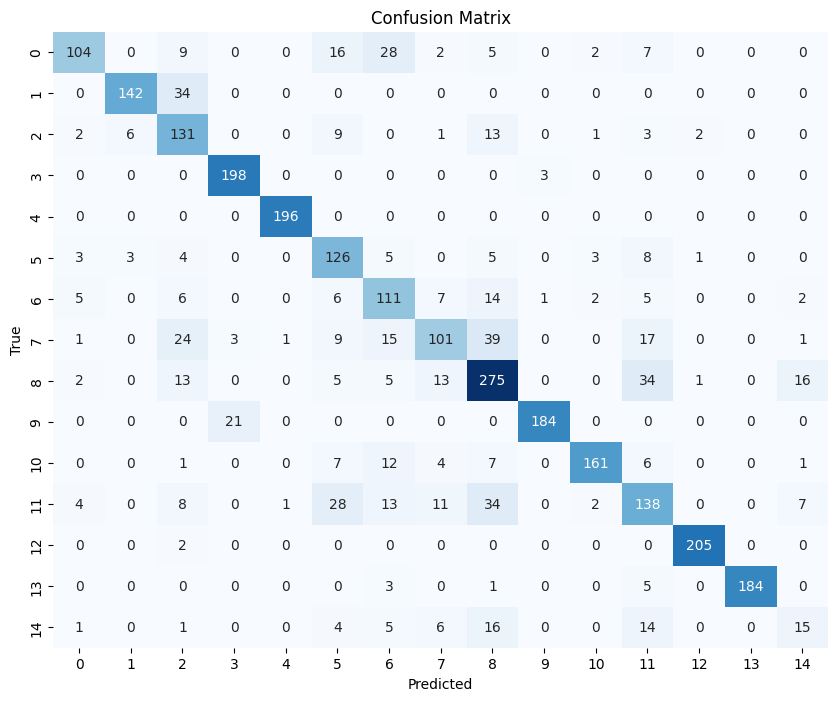

                                               precision    recall  f1-score   support

                Advance Stage_Alopecia areata       0.85      0.60      0.71       173
                     Advance Stage_Dermatitis       0.94      0.81      0.87       176
        Advance Stage_Female pattern baldness       0.56      0.78      0.65       168
                   Advance Stage_Folliculitis       0.89      0.99      0.94       201
                  Advance Stage_Lichen Planus       0.99      1.00      0.99       196
          Advance Stage_Male pattern baldness       0.60      0.80      0.68       158
        Early stage hair loss_Alopecia areata       0.56      0.70      0.62       159
             Early stage hair loss_Dermatitis       0.70      0.48      0.57       211
Early stage hair loss_Female pattern baldness       0.67      0.76      0.71       364
           Early stage hair loss_Folliculitis       0.98      0.90      0.94       205
          Early stage hair loss_Lichen Pla

In [46]:
# Get the true labels and predicted labels for the test set
true_labels = test_gen.classes  # Use test_gen.classes to get true labels
predicted_labels = model.predict(test_gen).argmax(axis=1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)